<a href="https://www.kaggle.com/code/pratimascripts/01-fraud-detection-eda?scriptVersionId=157991506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,VotingClassifier
from sklearn.preprocessing import MinMaxScaler,LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso, ElasticNet
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,VotingRegressor
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train_transaction=pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('../input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')

In [4]:
train_df = train_transaction.merge(train_identity, how="left", on="TransactionID")

test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [5]:
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

# EDA

In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

In [7]:
check_df(train_df)

##################### Shape #####################
(590540, 434)
##################### Types #####################
TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4

In [8]:
check_df(test_df)

##################### Shape #####################
(506691, 433)
##################### Types #####################
TransactionID       int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5

In [9]:
# source: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-592110
# Categorical Features:
# ProductCD
# card1 - card6
# addr1, addr2
# P_emaildomain
# R_emaildomain
# M1 - M9
# DeviceType
# DeviceInfo
# id_12 - id_38

In [10]:
cat_cols = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2", "P_emaildomain", "R_emaildomain",
            "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9", "DeviceType", "DeviceInfo", "id_12", "id_13", "id_14", "id_15",
            "id_16", "id_17", "id_18", "id_19", "id_20", "id_21", "id_22", "id_23", "id_24", "id_25", "id_26", "id_27", "id_28",
            "id_29", "id_30", "id_31", "id_32", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38"]

In [11]:
num_cols = [col for col in train_df.columns if col not in cat_cols and col not in ["TransactionID", "isFraud"]]

# Analysis of Categorical Variables 

In [12]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("\n")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [13]:
for col in cat_cols:
    cat_summary(train_df, col)

           ProductCD      Ratio
ProductCD                      
W             439670  74.452196
C              68519  11.602770
R              37699   6.383818
H              33024   5.592170
S              11628   1.969045


       card1     Ratio
card1                 
7919   14932  2.528533
9500   14162  2.398144
15885  10361  1.754496
17188  10344  1.751617
15066   7945  1.345379
12695   7091  1.200765
12544   6773  1.146916
6019    6771  1.146578
2803    6141  1.039896
7585    5334  0.903241
10616   5172  0.875809
12839   5129  0.868527
3154    4614  0.781319
2616    4410  0.746774
18132   4209  0.712737
9633    4158  0.704101
15497   3977  0.673451
16132   3929  0.665323
2884    3873  0.655840
16075   3748  0.634673
11207   3693  0.625360
10112   3560  0.602838
7508    3490  0.590985
10057   3166  0.536119
12501   3152  0.533749
7826    3006  0.509026
16659   2988  0.505978
12577   2891  0.489552
5812    2818  0.477190
7664    2792  0.472788
7861    2774  0.469740
6530    2714  0

# Analysis of Numerical Variables 

In [14]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")
    print("\n")

In [15]:
for col in num_cols:
    num_summary(train_df, col)

count    5.905400e+05
mean     7.372311e+06
std      4.617224e+06
min      8.640000e+04
5%       7.519465e+05
10%      1.361004e+06
20%      2.310160e+06
30%      3.864164e+06
40%      5.592304e+06
50%      7.306528e+06
60%      8.745782e+06
70%      1.043800e+07
80%      1.219285e+07
90%      1.399091e+07
95%      1.485787e+07
99%      1.562977e+07
max      1.581113e+07
Name: TransactionDT, dtype: float64
#####################################


count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
5%           20.000000
10%          25.950000
20%          35.950000
30%          49.000000
40%          57.950000
50%          68.769000
60%         100.000000
70%         117.000000
80%         159.950000
90%         275.293000
95%         445.000000
99%        1104.000000
max       31937.391000
Name: TransactionAmt, dtype: float64
#####################################


count    238269.000000
mean        118.502180
std         371.872026
min          

# Class Number of Numerical Variables

In [16]:
for col in num_cols: 
    print(f"{col}: {len(train_df[col].value_counts())}")

TransactionDT: 573349
TransactionAmt: 20902
dist1: 2651
dist2: 1751
C1: 1657
C2: 1216
C3: 27
C4: 1260
C5: 319
C6: 1328
C7: 1103
C8: 1253
C9: 205
C10: 1231
C11: 1476
C12: 1199
C13: 1597
C14: 1108
D1: 641
D2: 641
D3: 649
D4: 808
D5: 688
D6: 829
D7: 597
D8: 12353
D9: 24
D10: 818
D11: 676
D12: 635
D13: 577
D14: 802
D15: 859
V1: 2
V2: 9
V3: 10
V4: 7
V5: 7
V6: 10
V7: 10
V8: 9
V9: 9
V10: 5
V11: 6
V12: 4
V13: 7
V14: 2
V15: 8
V16: 15
V17: 16
V18: 16
V19: 8
V20: 15
V21: 6
V22: 9
V23: 14
V24: 14
V25: 7
V26: 13
V27: 4
V28: 4
V29: 6
V30: 8
V31: 8
V32: 15
V33: 7
V34: 13
V35: 4
V36: 6
V37: 55
V38: 55
V39: 16
V40: 18
V41: 2
V42: 9
V43: 9
V44: 49
V45: 49
V46: 7
V47: 9
V48: 6
V49: 6
V50: 6
V51: 7
V52: 9
V53: 6
V54: 7
V55: 18
V56: 52
V57: 7
V58: 11
V59: 17
V60: 17
V61: 7
V62: 11
V63: 8
V64: 8
V65: 2
V66: 8
V67: 9
V68: 3
V69: 6
V70: 7
V71: 7
V72: 11
V73: 8
V74: 9
V75: 5
V76: 7
V77: 31
V78: 32
V79: 8
V80: 20
V81: 20
V82: 8
V83: 8
V84: 8
V85: 8
V86: 31
V87: 31
V88: 2
V89: 3
V90: 6
V91: 7
V92: 8
V93: 8
V94: 

# Class Number of Categorical Variables

In [17]:
for col in cat_cols: 
    print(f"{col}: {len(train_df[col].value_counts())}")

ProductCD: 5
card1: 13553
card2: 500
card3: 114
card4: 4
card5: 119
card6: 4
addr1: 332
addr2: 74
P_emaildomain: 59
R_emaildomain: 60
M1: 2
M2: 2
M3: 2
M4: 3
M5: 2
M6: 2
M7: 2
M8: 2
M9: 2
DeviceType: 2
DeviceInfo: 1786
id_12: 2
id_13: 54
id_14: 25
id_15: 3
id_16: 2
id_17: 104
id_18: 18
id_19: 522
id_20: 394
id_21: 490
id_22: 25
id_23: 3
id_24: 12
id_25: 341
id_26: 95
id_27: 2
id_28: 2
id_29: 2
id_30: 75
id_31: 130
id_32: 4
id_33: 260
id_34: 4
id_35: 2
id_36: 2
id_37: 2
id_38: 2


# Analysis of Categorical Variables According to Target Variable

In [18]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [19]:
for col in cat_cols:
    target_summary_with_cat(train_df,"isFraud",col)

           TARGET_MEAN
ProductCD             
C             0.116873
H             0.047662
R             0.037826
S             0.058996
W             0.020399


       TARGET_MEAN
card1             
1000      0.000000
1001      0.000000
1004      0.000000
1005      0.000000
1006      0.000000
1007      0.000000
1008      0.000000
1009      0.000000
1010      0.000000
1011      0.000000
1012      0.000000
1013      0.000000
1014      0.000000
1015      0.125000
1016      0.071429
1018      0.000000
1020      0.000000
1021      0.000000
1022      0.125000
1023      0.000000
1024      0.000000
1026      0.000000
1027      0.000000
1028      0.000000
1029      0.000000
1030      0.008130
1031      0.000000
1032      0.000000
1033      0.000000
1034      0.000000
1035      0.000000
1036      0.000000
1037      0.000000
1038      0.000000
1039      0.007547
1040      0.000000
1041      0.000000
1042      0.000000
1043      0.333333
1045      1.000000
1046      0.000000
1047      0.181818
1

# Analysis of Numerical Variables According to Target Variable

In [20]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n")
    print("#################################", end="\n\n")

In [21]:
for col in num_cols:
    target_summary_with_num(train_df, "isFraud", col)

         TransactionDT
isFraud               
0         7.360791e+06
1         7.690033e+06

#################################

         TransactionAmt
isFraud                
0            134.511665
1            149.244779

#################################

              dist1
isFraud            
0        117.360098
1        174.588854

#################################

              dist2
isFraud            
0        235.199758
1        201.472259

#################################

                C1
isFraud           
0        13.314952
1        35.535740

#################################

                C2
isFraud           
0        14.173283
1        45.509413

#################################

               C3
isFraud          
0        0.005840
1        0.000242

#################################

                C4
isFraud           
0         3.693878
1        15.077336

#################################

               C5
isFraud          
0        5.722537
1        1

# Missing Values

In [22]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    
    if na_name:
        return na_columns,missing_df

In [23]:
na_cols,missing_df=missing_values_table(train_df, True)
missing_df.reset_index(inplace=True)

               n_miss  ratio
id_24          585793  99.20
id_25          585408  99.13
id_07          585385  99.13
id_08          585385  99.13
id_21          585381  99.13
id_26          585377  99.13
id_27          585371  99.12
id_23          585371  99.12
id_22          585371  99.12
dist2          552913  93.63
D7             551623  93.41
id_18          545427  92.36
D13            528588  89.51
D14            528353  89.47
D12            525823  89.04
id_03          524216  88.77
id_04          524216  88.77
D6             517353  87.61
id_33          517251  87.59
id_10          515614  87.31
id_09          515614  87.31
D8             515614  87.31
D9             515614  87.31
id_30          512975  86.87
id_32          512954  86.86
id_34          512735  86.82
id_14          510496  86.45
V155           508595  86.12
V138           508595  86.12
V156           508595  86.12
V157           508595  86.12
V158           508595  86.12
V154           508595  86.12
V153          

# Outliers

In [24]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [25]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [26]:
for col in num_cols:
    print(col, check_outlier(train_df, col))

TransactionDT False
TransactionAmt True
dist1 True
dist2 True
C1 True
C2 True
C3 True
C4 True
C5 False
C6 True
C7 True
C8 True
C9 False
C10 True
C11 True
C12 True
C13 True
C14 True
D1 False
D2 False
D3 False
D4 False
D5 False
D6 False
D7 False
D8 False
D9 False
D10 False
D11 False
D12 False
D13 False
D14 False
D15 False
V1 True
V2 True
V3 True
V4 True
V5 True
V6 True
V7 True
V8 True
V9 True
V10 False
V11 False
V12 True
V13 True
V14 True
V15 True
V16 True
V17 True
V18 True
V19 True
V20 True
V21 True
V22 True
V23 True
V24 True
V25 True
V26 True
V27 True
V28 True
V29 True
V30 True
V31 True
V32 True
V33 True
V34 True
V35 True
V36 False
V37 True
V38 True
V39 True
V40 True
V41 True
V42 True
V43 True
V44 True
V45 True
V46 True
V47 True
V48 True
V49 False
V50 True
V51 True
V52 True
V53 True
V54 True
V55 True
V56 True
V57 True
V58 True
V59 True
V60 True
V61 True
V62 True
V63 True
V64 True
V65 True
V66 True
V67 True
V68 True
V69 False
V70 True
V71 True
V72 True
V73 True
V74 True
V75 True
V76 Tru

# Some Important Graphs

## Missing values graph

In [27]:
null_variables = train_df.isnull().sum()/len(train_df) * 100
null_variables = null_variables.drop(null_variables[null_variables == 0].index).sort_values(ascending=False)[:500]
null_variables

id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_03            88.768923
id_04            88.768923
D6               87.606767
id_33            87.589494
id_10            87.312290
id_09            87.312290
D8               87.312290
D9               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V155             86.123717
V138             86.123717
V156             86.123717
V157             86.123717
V158             86.123717
V154             86.123717
V153             86.123717
V161             86.123717
V162             86.123717
V139             86.123717
V

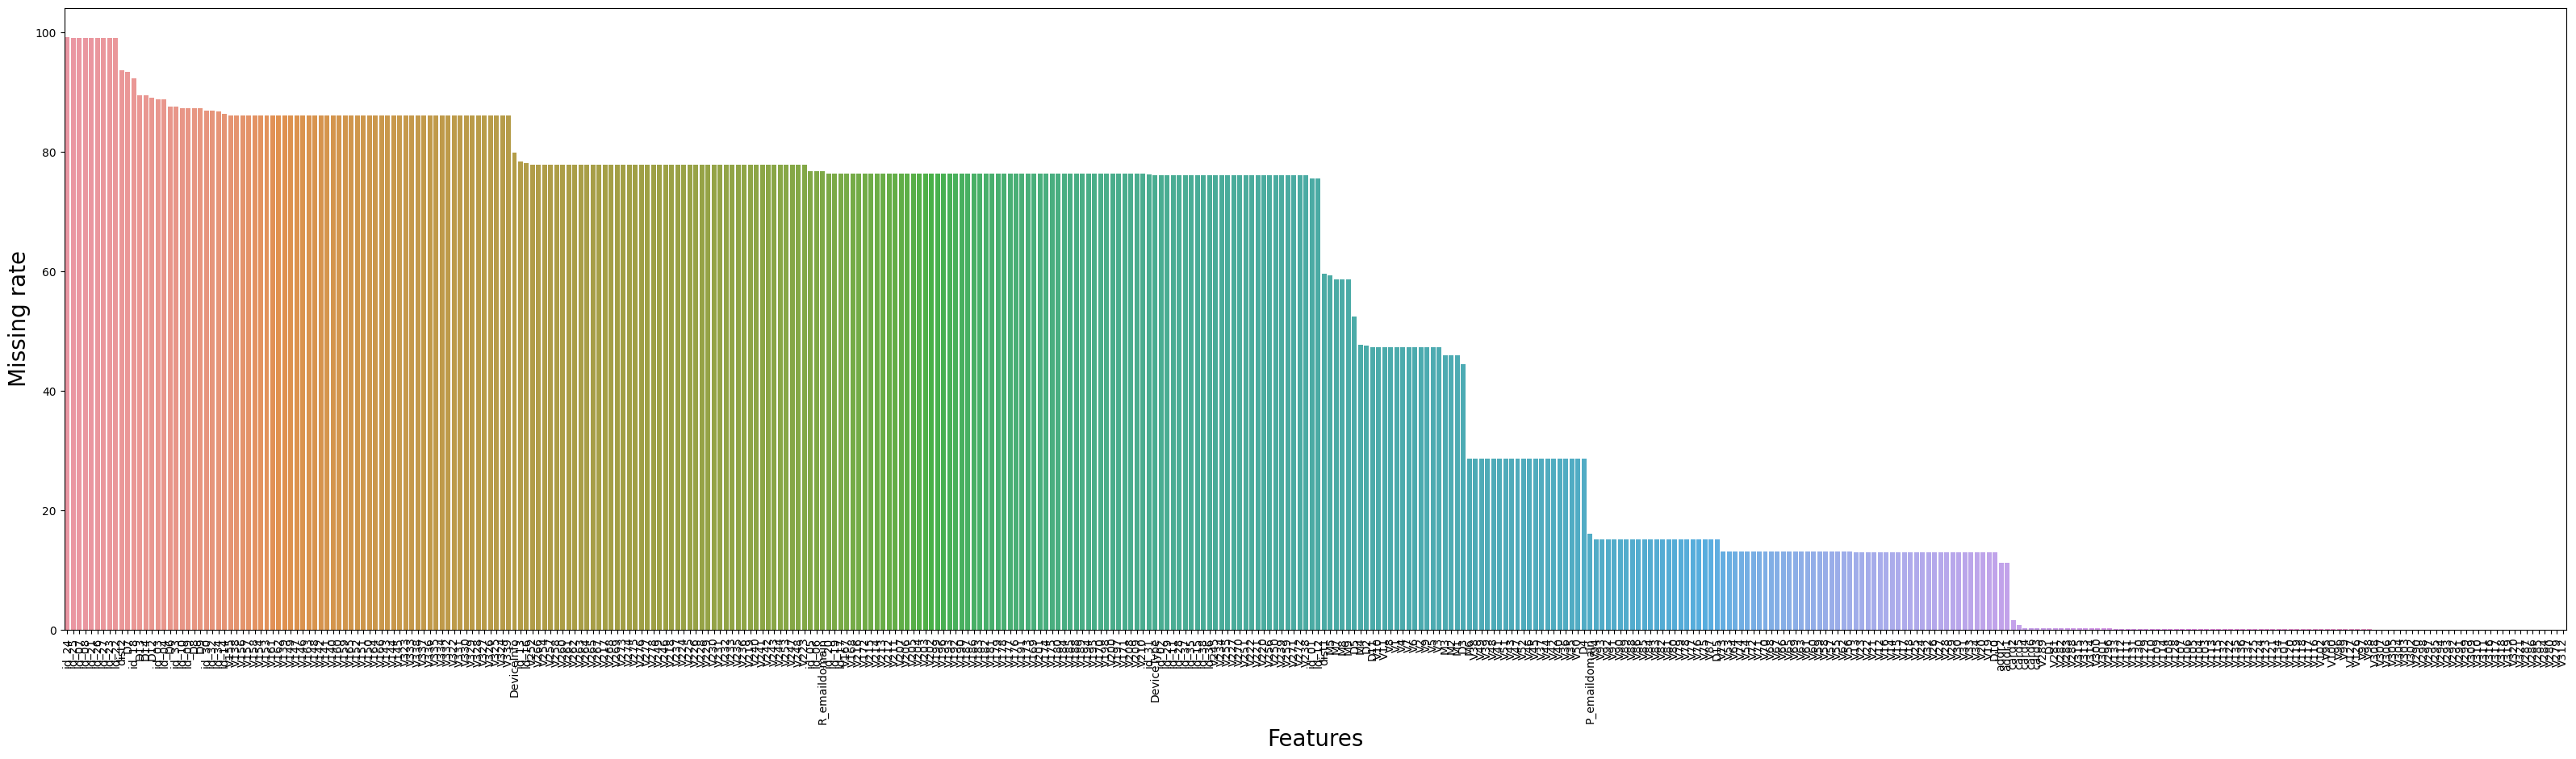

In [28]:
plt.subplots(figsize=(40,10))
plt.xticks(rotation=90) # Rotate x-axis labels
sns.barplot(x=null_variables.index, y=null_variables)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing rate', fontsize=20)
plt.show()

## Fraud Graph

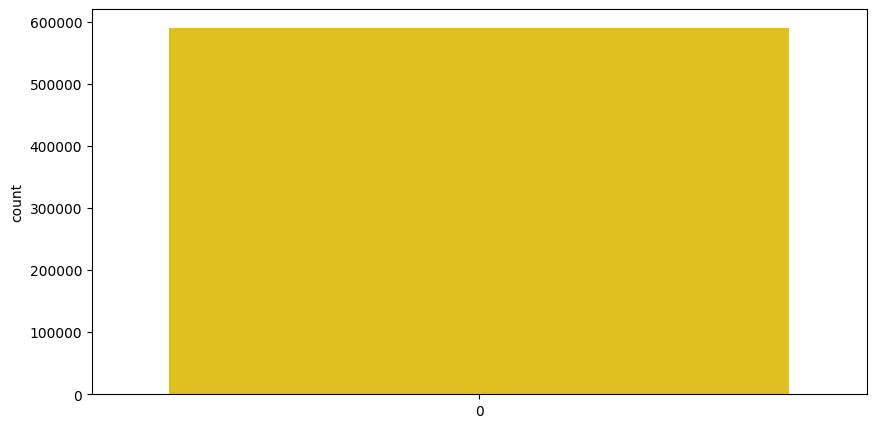

From total data  3.5 % contains fraud train
From total data  96.5 % contains legit train


In [29]:
#first on given fraud value on train data
plt.subplots(figsize=(10,5))
sns.countplot(train_df['isFraud'], palette=["#FFD500", "#005BBB"])
plt.show()
print('From total data ',np.round(train_df[train_df['isFraud']==1].shape[0]/train_df.shape[0]*100,2),'% contains fraud train')
print('From total data ',np.round(train_df[train_df['isFraud']==0].shape[0]/train_df.shape[0]*100,2),'% contains legit train')

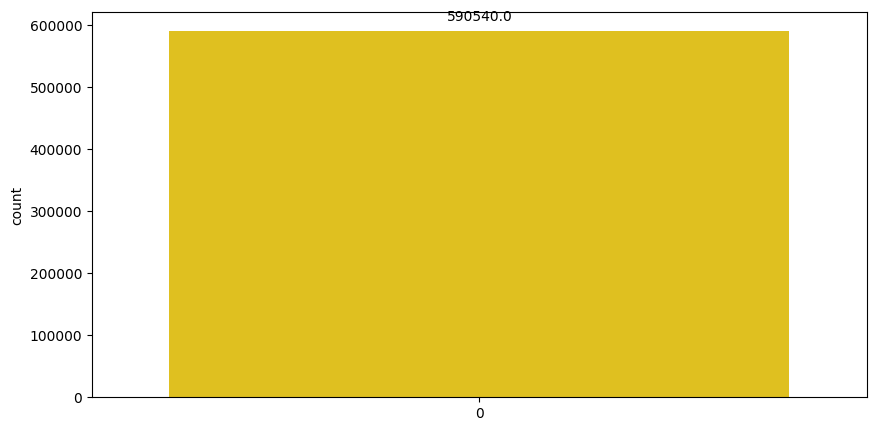

From total data, 3.5 % contains fraud in train
From total data, 96.5 % contains legitimate data in train


In [30]:
plt.subplots(figsize=(10, 5))
ax = sns.countplot(train_df['isFraud'], palette=["#FFD500", "#005BBB"])

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

fraud_percentage = np.round(train_df[train_df['isFraud'] == 1].shape[0] / train_df.shape[0] * 100, 2)
legit_percentage = np.round(train_df[train_df['isFraud'] == 0].shape[0] / train_df.shape[0] * 100, 2)

print('From total data,', fraud_percentage, '% contains fraud in train')
print('From total data,', legit_percentage, '% contains legitimate data in train')

## TransactionDT

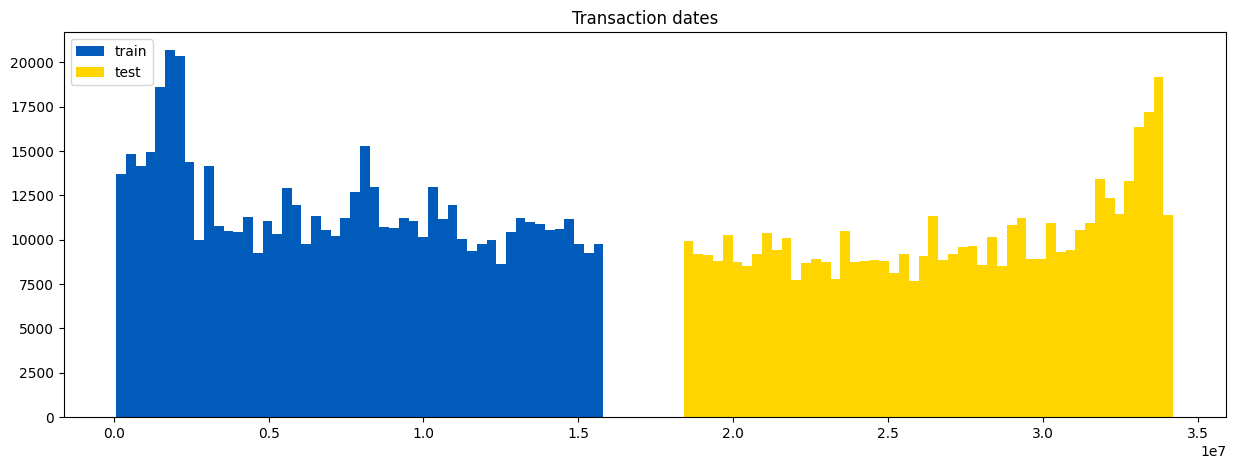

In [31]:
plt.subplots(figsize=(15,5))
plt.hist(train_df['TransactionDT'], label='train', bins=50, color="#005BBB");
plt.hist(test_df['TransactionDT'], label='test', bins=50, color="#FFD500");
plt.legend();
plt.title('Transaction dates');


In [32]:
print(f"Train TransactionDT min : {train_df.TransactionDT.min()}")
print(f"Train TransactionDT max : {train_df.TransactionDT.max()}")
print(f"Test TransactionDT min : {test_df.TransactionDT.min()}")
print(f"Test TransactionDT max : {test_df.TransactionDT.max()}")

Train TransactionDT min : 86400
Train TransactionDT max : 15811131
Test TransactionDT min : 18403224
Test TransactionDT max : 34214345


#### if the transactionDT is in seconds then (TransactionDT/(60x60x24))

Time interval of the total dataset is 394.9993634259259 days

Time interval of Train dataset is  181.99920138888888 days

Time interval of Test dataset is  182.99908564814814 days

The gap between train and test is 30.00107638888889 days

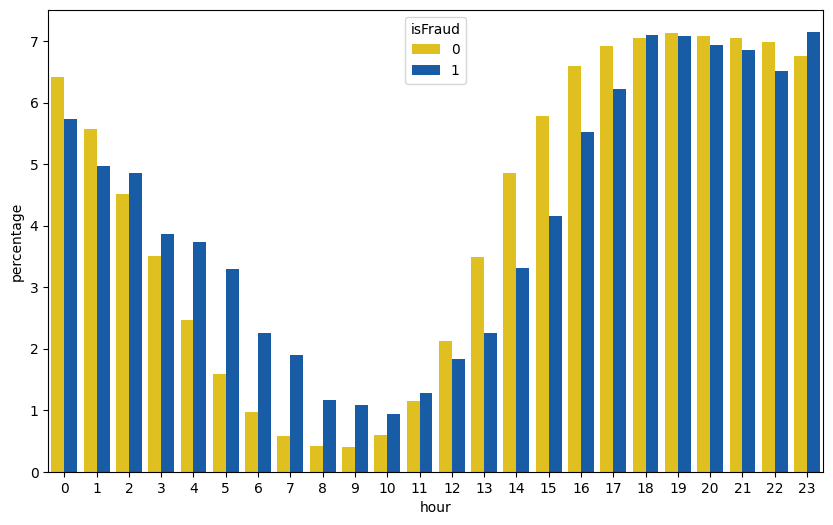

In [33]:
train_df['hour'] = (train_df['TransactionDT']//(3600))%24
test_df['hour'] = (test_df['TransactionDT']//(3600))%24

train_hour = (train_df.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))

plt.subplots(figsize=(10,6))
sns.barplot(x="hour", y="percentage", hue="isFraud", data=train_hour, palette=["#FFD500", "#005BBB"]);

## TransactionAMT

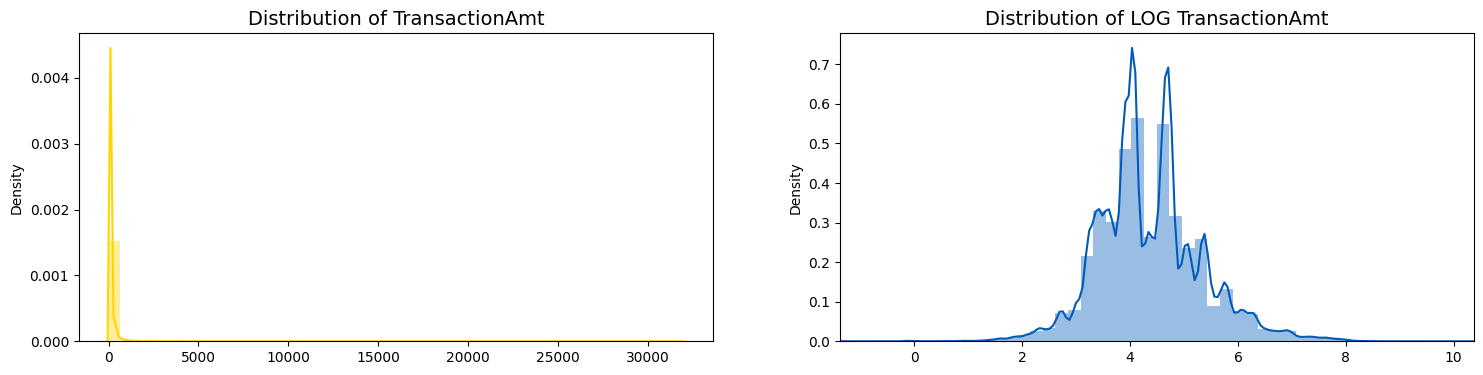

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_df['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='#FFD500')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='#005BBB')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

## ProductCD

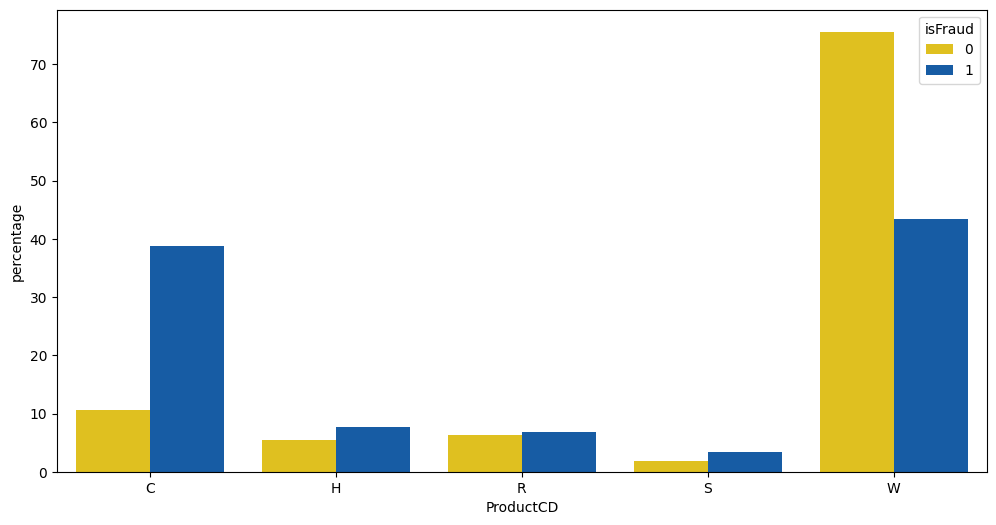

In [35]:
plt.figure(figsize=(12,6))

train_ProductCD = (train_df.groupby(['isFraud'])['ProductCD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=train_ProductCD, palette=["#FFD500", "#005BBB"]);


## card3

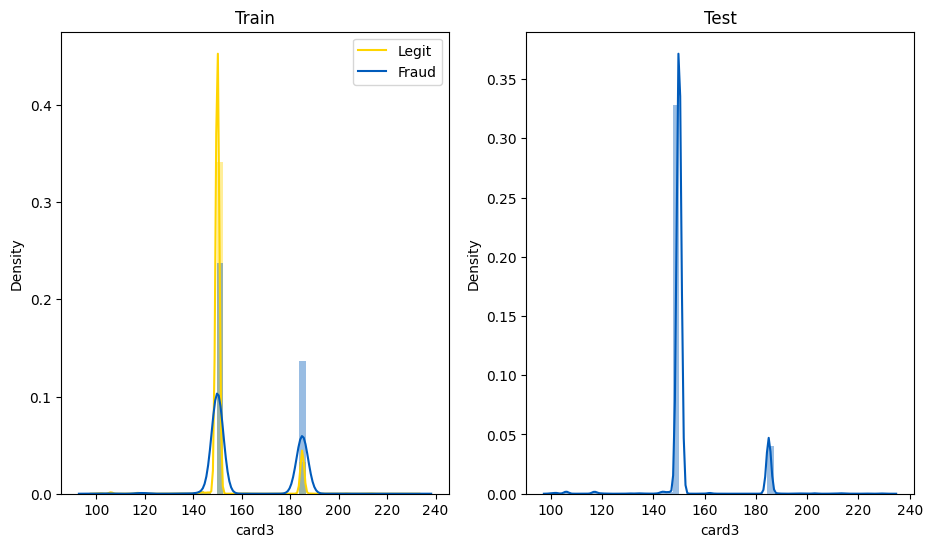

In [36]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.distplot(train_df[(train_df['isFraud']==0) & (~train_df['card3'].isnull())]['card3'], color="#FFD500")
sns.distplot(train_df[(train_df['isFraud']==1) & (~train_df['card3'].isnull())]['card3'], color="#005BBB")
plt.legend(['Legit','Fraud'])
plt.title('Train')
plt.subplot(1,2,2)
sns.distplot(test_df[~test_df['card3'].isnull()]['card3'], color="#005BBB")
plt.title('Test');

## card4

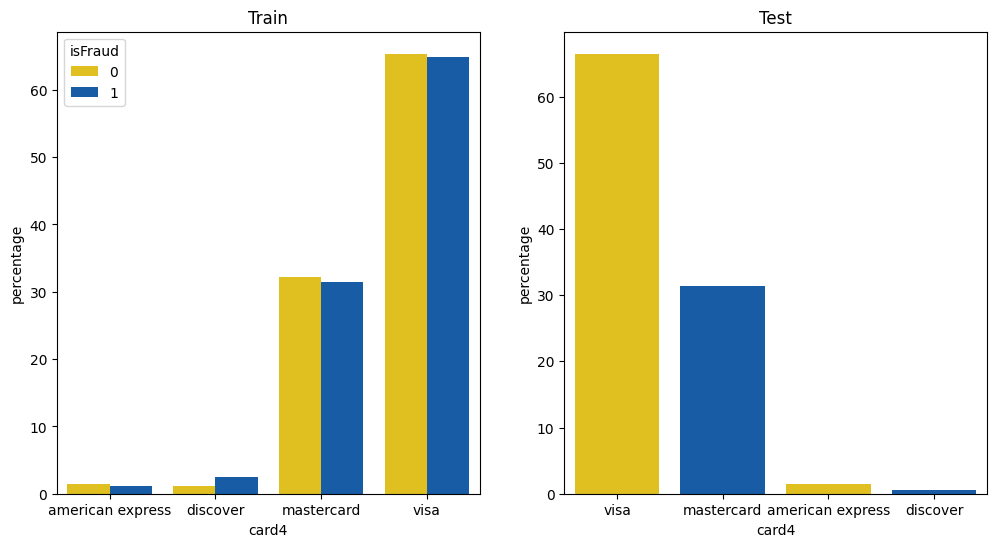

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train_card4 = (train_df[~train_df['card4'].isnull()].groupby(['isFraud'])['card4']
               .value_counts(normalize=True)
               .rename('percentage')
               .mul(100)
               .reset_index()
               .sort_values('card4'))

sns.barplot(x="card4", y="percentage", hue="isFraud", data=train_card4, palette=["#FFD500", "#005BBB"])
plt.title('Train')

plt.subplot(1, 2, 2)
test_card4 = (test_df[~test_df['card4'].isnull()]['card4']
              .value_counts(normalize=True)
              .mul(100)
              .rename('percentage')
              .reset_index())

sns.barplot(x="card4", y="percentage", data=test_card4, palette=["#FFD500", "#005BBB"])
plt.title('Test')

plt.show()

## D4 (for outliers)

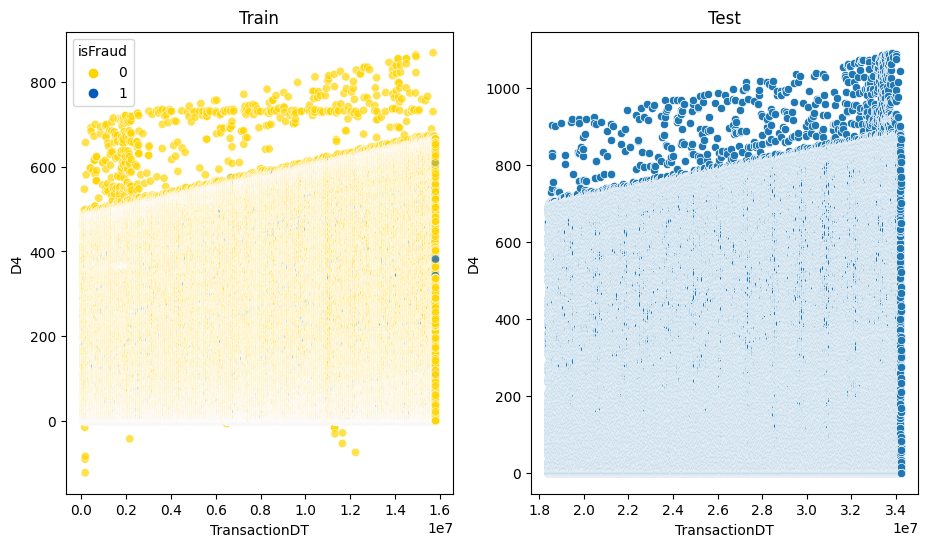

In [38]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
sns.scatterplot(x="TransactionDT",y="D4",hue="isFraud",data=train_df[~train_df['D4'].isnull()],alpha=0.7,hue_order=[0,1] \
                ,palette=["#FFD500", "#005BBB"] )
plt.title('Train')
plt.subplot(1,2,2)
sns.scatterplot(x="TransactionDT",y="D4",data=test_df[~test_df['D4'].isnull()])
plt.title('Test');